<a href="https://colab.research.google.com/github/ByteBelle-21/maze_solver/blob/main/maze_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import cv2

Saving maze1.png to maze1 (18).png


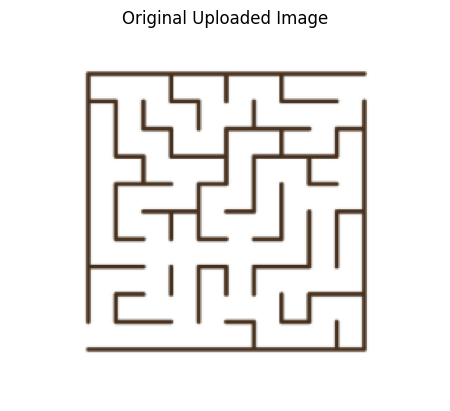

In [75]:
is_valid = False
filename = ""
while not is_valid :
  input_image = files.upload()
  filename = next(iter(input_image))
  is_valid = cv2.haveImageWriter(filename)
  if not is_valid :
    print("File format not supported. Upload new file!")
  else :
    opened_file = open(filename, "wb")
    opened_file.write(input_image[filename])

valid_image = cv2.imread(filename)
if valid_image is None:
  print("File doesn't exist")
  exit(0)
plt.imshow(valid_image)
plt.axis("off")
plt.title("Original Uploaded Image")
plt.show()

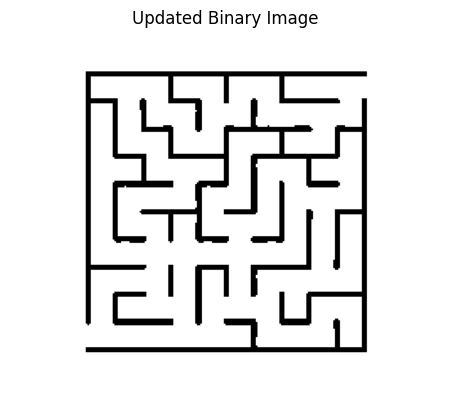

In [76]:
gray_image = cv2.cvtColor(valid_image, cv2.COLOR_BGR2GRAY)
binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, 2)
plt.imshow(binary_image, cmap='gray')
plt.axis("off")
plt.title("Updated Binary Image")
plt.show()

In [77]:
image_matrix = (binary_image == 255).astype(int)
print("Converted image matrix")
print(image_matrix)

Converted image matrix
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [78]:
def opening_top_border(image_matrix):
  height, width = image_matrix.shape
  opening = []
  for x in range(height):
    wall_found = False
    for y in range(width):
      if image_matrix[x][y] == 1 and wall_found:
        opening.append((x, y))
        if y == (width - 1):
          return []
      elif image_matrix[x][y] == 0 and not wall_found:
        wall_found = True
      elif image_matrix[x][y] == 0 and wall_found and image_matrix[x][y-1] == 1:
        return opening
  return opening

def opening_bottom_border(image_matrix):
  height, width = image_matrix.shape
  opening = []
  for x in reversed(range(height)):
    wall_found = False
    for y in range(width):
      if image_matrix[x][y] == 1 and wall_found:
        opening.append((x, y))
        if y == (width - 1):
          return []
      elif image_matrix[x][y] == 0 and not wall_found:
        wall_found = True
      elif image_matrix[x][y] == 0 and wall_found and image_matrix[x][y-1] == 1:
        return opening
  return opening


def opening_left_border(image_matrix):
  height, width = image_matrix.shape
  opening = []
  for y in range(width):
    wall_found = False
    for x in range(height):
      if image_matrix[x][y] == 1 and wall_found:
        opening.append((x, y))
        if x == (height - 1):
          return []
      elif image_matrix[x][y] == 0 and not wall_found:
        wall_found = True
      elif image_matrix[x][y] == 0 and wall_found and image_matrix[x-1][y] == 1:
        return opening
  return opening

def opening_right_border(image_matrix):
  height, width = image_matrix.shape
  opening = []
  for y in reversed(range(width)):
    wall_found = False
    for x in range(height):
      if image_matrix[x][y] == 1 and wall_found:
        opening.append((x, y))
        if x == (height - 1):
          return []
      elif image_matrix[x][y] == 0 and not wall_found:
        wall_found = True
      elif image_matrix[x][y] == 0 and wall_found and image_matrix[x-1][y] == 1:
        return opening
  return opening

In [84]:
top_opening = opening_top_border(image_matrix)
bottom_opening = opening_bottom_border(image_matrix)
left_opening = opening_left_border(image_matrix)
right_opening  =  opening_right_border(image_matrix)

start = (-1, -1)
end = (-1, -1)

if top_opening == [] and bottom_opening == [] and left_opening == [] and right_opening == []:
  print("No opening found")
  exit(0)

if len(top_opening) > 0:
  if start == (-1, -1):
    start = (top_opening[0][0],((top_opening[0][1] + top_opening[-1][1]) // 2))
  elif end == (-1, -1):
    end = (top_opening[0][0],((top_opening[0][1] + top_opening[-1][1]) // 2))

if len(bottom_opening) > 0:
  if start == (-1, -1):
    start = (bottom_opening[0][0],((bottom_opening[0][1] + bottom_opening[-1][1]) // 2))
  elif end == (-1, -1):
    end = (bottom_opening[0][0],((bottom_opening[0][1] + bottom_opening[-1][1]) // 2))

if len(left_opening) > 0:
  if start == (-1, -1):
    start = (((left_opening[0][0] + left_opening[-1][0]) // 2), left_opening[0][1])
  elif end == (-1, -1):
    end = (((left_opening[0][0] + left_opening[-1][0]) // 2), left_opening[0][1])

if len(right_opening) > 0:
  if start == (-1, -1):
    start = (((right_opening[0][0] + right_opening[-1][0]) // 2), right_opening[0][1])
  elif end == (-1, -1):
    end = (((right_opening[0][0] + right_opening[-1][0]) // 2), right_opening[0][1])


print("Start position is", start)
print("End position is", end)

Start position is (180, 45)
End position is (33, 211)
